In [9]:
%matplotlib inline

from math import floor, ceil
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import h5py
from tqdm import tqdm
from scipy.stats import norm
from sklearn.model_selection import train_test_split
from keras import backend as K
from keras.models import Model
from keras.layers import Input, Conv2D, UpSampling2D, Activation, MaxPooling2D, Dropout, Flatten
from keras.layers import Dense, Reshape, Lambda, Layer, Conv2DTranspose
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator, load_img, array_to_img, img_to_array
from keras import metrics
from keras.callbacks import TensorBoard

In [2]:
datagen = ImageDataGenerator(
            rotation_range=0,
            width_shift_range=0,
            height_shift_range=0,
            rescale=1./255,
            shear_range=0.1,
            zoom_range=0,
            horizontal_flip=False,
            fill_mode='nearest',
            data_format="channels_last")

### Based off of

https://github.com/fchollet/keras/blob/master/examples/variational_autoencoder.py
https://github.com/fchollet/keras/blob/master/examples/variational_autoencoder_deconv.py

In [3]:
img_rows, img_cols, img_chns = 46, 80, 3

if K.image_data_format() == 'channels_first':
    image_size = (img_chns, img_rows, img_cols)
else:
    image_size = (img_rows, img_cols, img_chns)

batch_size = 10
original_dim = image_size[0] * image_size[1] * image_size[2]
latent_dim = 256
intermediate_dim = 2000
epochs = 1000
epsilon_std = 1.0
# number of convolutional filters to use
filters = 64
# convolution kernel size
num_conv = 3


x = Input(shape=image_size)
conv_1 = Conv2D(img_chns,
                kernel_size=(2, 2),
                padding='same', activation='relu',
                name="conv_1")(x)
conv_2 = Conv2D(filters,
                kernel_size=(2, 2),
                padding='same', activation='relu',
                strides=(2, 2),
                name="conv_2")(conv_1)
conv_3 = Conv2D(filters,
                kernel_size=num_conv,
                padding='same', activation='relu',
                strides=1,
                name="conv_3")(conv_2)
conv_4 = Conv2D(filters,
                kernel_size=num_conv,
                padding='same', activation='relu',
                strides=1,
                name="conv_4")(conv_3)
flat = Flatten()(conv_4)
hidden = Dense(intermediate_dim, activation='relu', name="hidden")(flat)
z_mean = Dense(latent_dim, name="z_mean")(hidden)
z_log_var = Dense(latent_dim, name="z_log_var")(hidden)


def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0.,
                              stddev=epsilon_std)
    return z_mean + K.exp(z_log_var / 2) * epsilon

# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

# we instantiate these layers separately so as to reuse them later
decoder_hid = Dense(intermediate_dim, activation='relu', name="decoder_hid")
decoder_upsample = Dense(filters * int(img_rows / 2) * int(img_cols / 2), activation='relu', name="decoder_upsample")

if K.image_data_format() == 'channels_first':
    output_shape = (batch_size, filters, int(img_rows / 2), int(img_cols / 2))
else:
    output_shape = (batch_size, int(img_rows / 2), int(img_cols / 2), filters)
    
decoder_reshape = Reshape(output_shape[1:], name="decoder_reshape")
decoder_deconv_1 = Conv2DTranspose(filters,
                                   kernel_size=num_conv,
                                   padding='same',
                                   strides=1,
                                   activation='relu',
                                   name="decoder_deconv_1")
decoder_deconv_2 = Conv2DTranspose(filters,
                                   kernel_size=num_conv,
                                   padding='same',
                                   strides=1,
                                   activation='relu',
                                   name="decoder_deconv_2")

if K.image_data_format() == 'channels_first':
    output_shape = (batch_size, filters, int(img_rows / 2) + 1, int(img_cols / 2) + 1)
else:
    output_shape = (batch_size, int(img_rows / 2) + 1, int(img_cols / 2) + 1, filters)
    
decoder_deconv_3_upsamp = Conv2DTranspose(filters,
                                          kernel_size=(3, 3),
                                          strides=(2, 2),
                                          padding='valid',
                                          activation='relu',
                                          name="decoder_deconv_3_upsamp")
decoder_mean_squash = Conv2D(img_chns,
                             kernel_size=2,
                             padding='valid',
                             activation='sigmoid',
                             name="decoder_mean_squash")

hid_decoded = decoder_hid(z)
up_decoded = decoder_upsample(hid_decoded)
reshape_decoded = decoder_reshape(up_decoded)
deconv_1_decoded = decoder_deconv_1(reshape_decoded)
deconv_2_decoded = decoder_deconv_2(deconv_1_decoded)
x_decoded_relu = decoder_deconv_3_upsamp(deconv_2_decoded)
x_decoded_mean_squash = decoder_mean_squash(x_decoded_relu)

# Custom loss layer
class CustomVariationalLayer(Layer):
    def __init__(self, **kwargs):
        self.is_placeholder = True
        super(CustomVariationalLayer, self).__init__(**kwargs)

    def vae_loss(self, x, x_decoded_mean_squash):
        x = K.flatten(x)
        x_decoded_mean_squash = K.flatten(x_decoded_mean_squash)
        xent_loss = img_rows * img_cols * metrics.binary_crossentropy(x, x_decoded_mean_squash)
        kl_loss = - 0.5 * K.mean(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
        return K.mean(xent_loss + kl_loss)

    def call(self, inputs):
        x = inputs[0]
        x_decoded_mean_squash = inputs[1]
        loss = self.vae_loss(x, x_decoded_mean_squash)
        self.add_loss(loss, inputs=inputs)
        # We don't use this output.
        return x


y = CustomVariationalLayer()([x, x_decoded_mean_squash])

vae = Model(x, y)
vae.compile(optimizer='rmsprop', loss=None)

vae.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 46, 80, 3)     0                                            
____________________________________________________________________________________________________
conv_1 (Conv2D)                  (None, 46, 80, 3)     39          input_1[0][0]                    
____________________________________________________________________________________________________
conv_2 (Conv2D)                  (None, 23, 40, 64)    832         conv_1[0][0]                     
____________________________________________________________________________________________________
conv_3 (Conv2D)                  (None, 23, 40, 64)    36928       conv_2[0][0]                     
___________________________________________________________________________________________

/home/carson/Documents/code/ml-testing/.env/lib/python3.5/site-packages/ipykernel_launcher.py:128: UserWarning: Output "custom_variational_layer_1" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "custom_variational_layer_1" during training.


In [4]:
flow_gen = datagen.flow_from_directory("data/good", shuffle=True, target_size=image_size[:-1], batch_size=batch_size, class_mode=None)
print("Grabbing images...")
image_batch = next(flow_gen)
for _ in tqdm(range(5)):
    new_batch = next(flow_gen)
    image_batch = np.concatenate([image_batch, new_batch])

# ignore y, we dont need it
x_train, x_test, _, _ = train_test_split(image_batch, list(range(len(image_batch))), test_size=0.2)
print("x_train shape: ", np.asarray(x_train).shape)
print("x_test shape: ", np.asarray(x_test).shape)

Found 2819 images belonging to 1 classes.
Grabbing images...


100%|██████████| 5/5 [00:02<00:00,  1.60it/s]

x_train shape:  (48, 46, 80, 3)
x_test shape:  (12, 46, 80, 3)


In [10]:
tensorboard = TensorBoard(log_dir='./logs', histogram_freq=0,
                          write_graph=True, write_images=False)

vae.fit(x_train,
        shuffle=True,
        epochs=epochs,
        batch_size=24,
        validation_data=(x_test, None),
        callbacks=[tensorboard])

# build a model to project inputs on the latent space
encoder = Model(x, z_mean)

Train on 48 samples, validate on 12 samples
Epoch 1/528
48/48 [==============================] - 4s - loss: 1715.2714 - val_loss: 2327.4207
Epoch 2/528
48/48 [==============================] - 5s - loss: 1719.4687 - val_loss: 2344.1025
Epoch 3/528
48/48 [==============================] - 5s - loss: 1718.8333 - val_loss: 2335.3613
Epoch 4/528
48/48 [==============================] - 5s - loss: 1718.8378 - val_loss: 2339.3508
Epoch 5/528
48/48 [==============================] - 4s - loss: 1725.1622 - val_loss: 2305.6360
Epoch 6/528
48/48 [==============================] - 4s - loss: 1729.4164 - val_loss: 2351.5244
Epoch 7/528
48/48 [==============================] - 5s - loss: 1740.0171 - val_loss: 

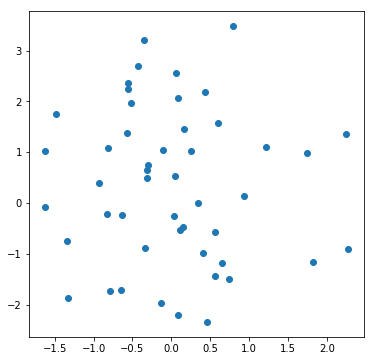

In [13]:
# display a 2D plot of the digit classes in the latent space
# x_test_encoded = encoder.predict(x_test, batch_size=batch_size)
x_train_encoded = encoder.predict(x_train, batch_size=batch_size)
plt.figure(figsize=(6, 6))
# plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test)
plt.scatter(x_train_encoded[:, 0], x_train_encoded[:, 1])
# plt.colorbar()
plt.show()

In [16]:
# build a generator that can sample from the learned distribution
decoder_input = Input(shape=(latent_dim,), name="decoder_input")
_hid_decoded = decoder_hid(decoder_input)
_up_decoded = decoder_upsample(_hid_decoded)
_reshape_decoded = decoder_reshape(_up_decoded)
_deconv_1_decoded = decoder_deconv_1(_reshape_decoded)
_deconv_2_decoded = decoder_deconv_2(_deconv_1_decoded)
_x_decoded_relu = decoder_deconv_3_upsamp(_deconv_2_decoded)
_x_decoded_mean_squash = decoder_mean_squash(_x_decoded_relu)
generator = Model(decoder_input, _x_decoded_mean_squash)

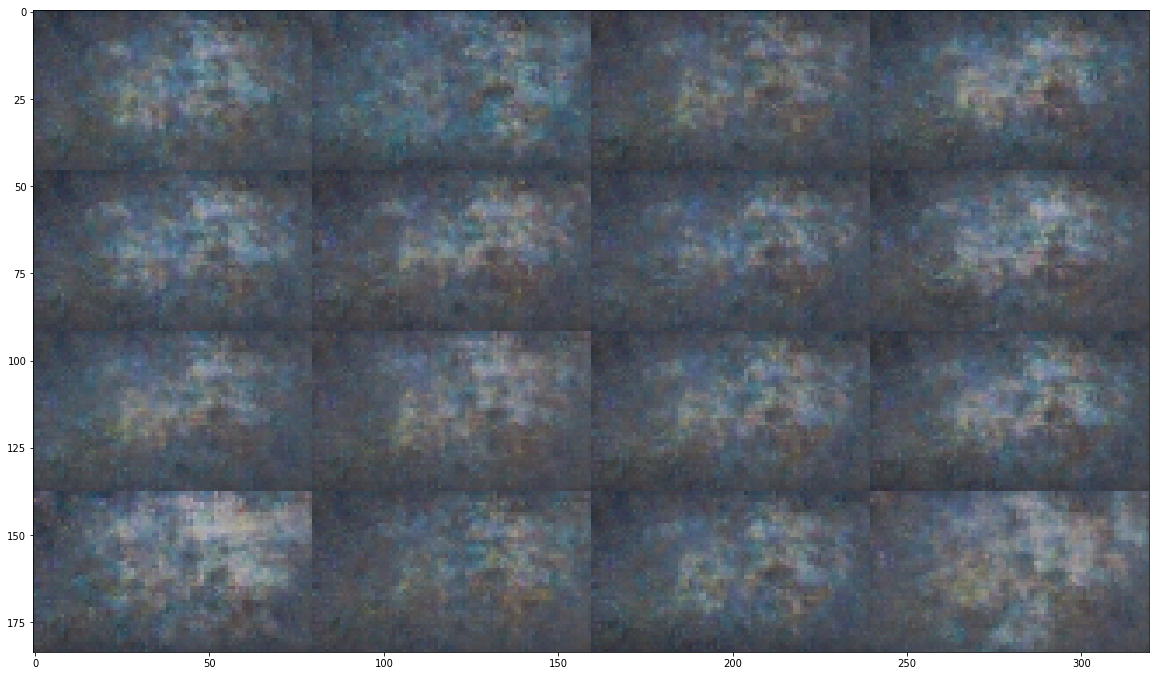

In [26]:
# display a 2D manifold
n = 4  # figure with 20x20 images
out_size = image_size
figure = np.zeros((out_size[0] * n, out_size[1] * n, img_chns))
# linearly spaced coordinates on the unit square were transformed through the inverse CDF (ppf) of the Gaussian
# to produce values of the latent variables z, since the prior of the latent space is Gaussian
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.random.random_sample(size=(n*n, latent_dim,))
        x_decoded = generator.predict(z_sample)
        out = x_decoded[i+j].reshape(out_size)
        figure[i * out_size[0]: (i + 1) * out_size[0],
               j * out_size[1]: (j + 1) * out_size[1]] = out

plt.figure(figsize=(20, 12))
plt.imshow(figure)
plt.show()